# Assignment 1: Introduction to the Fully Recurrent Network

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.


## Exercise 1: Numerical stability of the binary cross-entropy loss function

We will use the binary cross-entropy loss function to train our RNN, which is defined as 
$$
L_{\text{BCE}}(\hat y, y) = -y \log \hat y - (1-y) \log (1-\hat y),
$$
where $y$ is the label and $\hat y$ is a prediction, which comes from a model (e.g. an RNN) and is usually sigmoid-activated, i.e., we have
$$
\hat y = \sigma(z) = \frac{1}{1+e^{-z}}.
$$
The argument $z$ is called *logit*. For reasons of numerical stability it is better to let the model emit the logit $z$ (instead of the prediction $\hat y$) and incorporate the sigmoid activation into the loss function. Explain why this is the case and how we can gain numerical stability by combining the two functions $L_{\text{BCE}}(\hat y, y)$ and $\sigma(z)$ into one function $L(z, y) = L_{\text{BCE}}(\sigma(z), y)$. 

*Hint: Prove that $\log(1+e^{z}) = \log (1+e^{-|z|}) + \max(0, z)$ and argue why the right-hand side is numerically more stable. Finally, express $L(z,y)$ in terms of that form.*

########## YOUR SOLUTION HERE ##########

L(y,Y)=−ylog(Y)−(1−y)log(1−Y)
Y = σ(z) = 1/(1+e^(-z) )
L(z,Y) = -ylog(1/(1+e^(-z) ))−(1−y)log(1−1/(1+e^(-z) ))
          =-ylog(1+e^(-z))−(1−y)log(1+e^z)
log(1+e^z) = log(1+e^(-|z|)) + max(0
,z)
in cas 0<z so z is positive and max(0,z) = z:
log(1+e^(-|z|)) + max(0,z) = log(1+e^(-z)) + z
log(1+e^z) = log((1+e^(-z))/e^(-z) ) = log(1+e^(-z)) - log(e^(-z)) = log(1+e^(-z
)) + z
in case 0>z so z is negative and max(0,z) = 0:
log(1+e^(-|z|)) + max(0,z)= log(1+e^(-|-z|)) + 0 = log(1+e^z)

So plugging the logit z into the BCE loss make us avoid the computations of extreme numbers close to 0 or clause to 1, so achieving numerical stability. And using this form [log(1+e^z) = log(1+e^(-|z|)) + max(0,z)] makes makes it easy to handle positive and negative extreme numbers so avoiding overflow and underflow in the computation of exponential terms.


## Exercise 2: Derivative of the loss

Calculate the derivative of the binary cross-entropy loss function $L(z, y)$ with respect to the logit $z$.

########## YOUR SOLUTION HERE ##########

L(y,Y)=−ylog(Y)−(1−y)log(1−Y)
Y = σ(z)
L(y,σ(z))=−ylog(σ(z))−(1−y)log(1− σ(z))
 (dσ(z))/dz = σ(z)(1- σ(z))
(dL(y,σ(z)))/dz = -y1/(σ(z))   (dσ(z))/dz – (1-y) 1/(1-σ(z) )(-  dσ(z)/dz)
                = -y1/(σ(z))  σ(z)(1- σ(z)) – (1-y) 1/(1-σ(z) )(- σ(z)(1- σ(z)))
                = -y(1- σ(z)) +(1-y) σ(z)
                = -y + σ(z)


## Exercise 3: Initializing the network
Consider the fully recurrent network
$$
s(t) = W x(t) + R a(t-1) \\
a(t) = \tanh(s(t)) \\
z(t) = V a(t) \\
\hat y(t) = \sigma(z(t))
$$
for $t \in \mathbb{N}, x(t) \in \mathbb{R}^{D}, s(t) \in \mathbb{R}^{I}, a(t) \in \mathbb{R}^{I}, z(t) \in \mathbb{R}^K, \hat y(t) \in \mathbb{R}^K$ and $W, R, V$ are real matrices of appropriate sizes and $\hat a(0) = 0$. 

*Compared to the lecture notes we choose $f(x) = \tanh(x) = (e^x - e^{-x})(e^x + e^{-x})^{-1}$ and $\varphi(x) = \sigma(x) = (1+e^{-x})^{-1}$. Further, we introduced an auxiliary variable $z(t)$ and transposed the weight matrices.*

Write a function `init` that takes a `model` and integers $D, I, K$ as arguments and stores the matrices $W, R, V$ as members `model.W`, `model.R`, `model.V`, respectively. The matrices should be `numpy` arrays of appropriate sizes and filled with random values that are uniformly distributed between -0.01 and 0.01. 

In [42]:
%matplotlib inline
import numpy as np
from scipy.special import expit as sigmoid

class Obj(object):
    pass

model = Obj()
T, D, I, K = 10, 3, 5, 1

def init(model, D, I, K):
    ########## YOUR SOLUTION HERE ##########
    model.R = np.random.uniform(-0.01, 0.01,I)
    model.W = np.random.uniform(-0.01, 0.01,D)
    model.V = np.random.uniform(-0.01, 0.01,K)
    print(model.R)
    print(model.W)
    print(model.V)

Obj.init = init
model.init(D, I, K)

[0.00207632 0.00913929 0.00174411 0.00173068 0.00944919]
[-0.00614752  0.00070916  0.00392682]
[-0.00971661]


## Exercise 4: The forward pass
Implement the forward pass for the fully recurrent network for sequence classification (many-to-one mapping). To this end, write a function `forward` that takes a `model`, a sequence of input vectors `x`, and a label `y` as arguments. The inputs will be represented as a `numpy` array of shape `(T, D)`. It should execute the behavior of the fully recurrent network and evaluate the (numerically stabilized) binary cross-entropy loss at the end of the sequence and return the resulting loss value. Store the sequence of hidden activations $(a(t))_{t=1}^T$ and the logit $z(T)$ into `model.a` and `model.z`, respectively. 

In [93]:
def forward(model, x, y):
    ########## YOUR SOLUTION HERE ##########

    T, D = x.shape  
    a_dim = model.R.shape[0]  
    a = np.zeros(a_dim)  
    model.a = []  
    
    for t in range(T):
        array_a = np.zeros((T, a_dim))
        a = np.tanh(np.dot(model.W, x[t]) + np.dot(model.R, a))
        array_a[T-1, :] = a
       
    model.a = array_a
    model.z = model.V * a
    z = model.z
    sigmoid_z = 1 / (1 + np.exp(-z))
    loss_L = -y * np.log(sigmoid_z) - (1 - y) * np.log(1 - sigmoid_z)
    
    return loss_L
Obj.forward = forward
model.forward(np.random.uniform(-1, 1, (T, D)), 1)

array([0.69317409, 0.69317411, 0.69317409, 0.69317409, 0.69317411])

## Exercise 5: The computational graph

Visualize the computational graph of the fully recurrent network unfolded in time. The graph should show the functional dependencies of the nodes $x(t), a(t), z(t), L(z(t), y(t))$ for $t \in \{1, 2, 3\}$. Use the package `networkx` in combination with `matplotlib` to draw a directed graph with labelled nodes and edges. If you need help take a look at [this guide](https://networkx.org/documentation/stable/tutorial.html). Make sure to arrange the nodes in a meaningful way. 

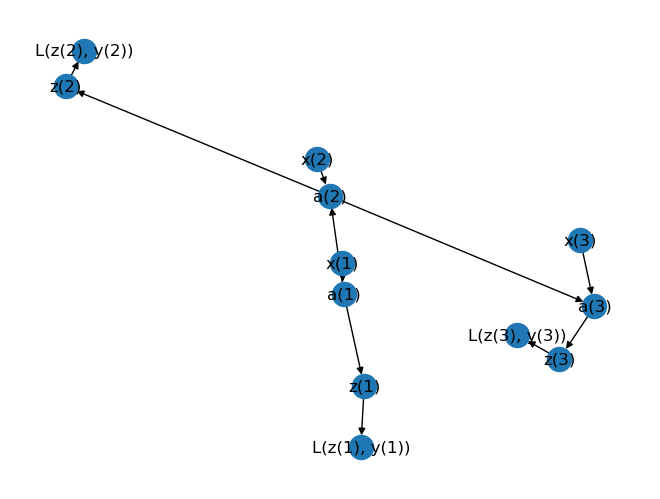

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

########## YOUR SOLUTION HERE ##########
G = nx.DiGraph()

for t in time_steps:
    G.add_node(f'L(z({t}), y({t}))')
    G.add_node(f'x({t})')
    G.add_node(f'z({t})')
    G.add_node(f'a({t})')
    if t > 1:
        G.add_edge(f'a({t-1})', f'a({t})')  
    G.add_edge(f'z({t})', f'L(z({t}), y({t}))') 
    G.add_edge(f'x({t})', f'a({t})')        
    G.add_edge(f'a({t})', f'z({t})')     
     

nx.draw(G, with_labels=True)

plt.show()
